# Laboratorio 4 - Informe

### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from torch.nn.functional import torch, cross_entropy

In [2]:
DATASET_FILE = "./dataset.csv"
dataset = pd.read_csv(DATASET_FILE, sep=",")
dataset.drop(columns=['pidnum','time'], inplace=True)
target = 'cid'
continuous_features = [
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]
features = [
    'trt', 
    'age', 
    'wtkg', 
    'hemo', 
    'homo', 
    'drugs', 
    'karnof',
    'oprior', 
    'z30', 
    'zprior', 
    'preanti', 
    'race', 
    'gender', 
    'str2', 
    'strat',
    'symptom', 
    'treat', 
    'offtrt', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820'
]

In [3]:
ds_train_complete, ds_test = train_test_split(dataset, test_size=0.2, random_state=0)

ds_train, ds_validation = train_test_split(ds_train_complete, test_size=0.1, random_state=0)

X_train = ds_train.drop(columns=['cid'])
y_train = ds_train['cid']

X_validation = ds_validation.drop(columns=['cid'])
y_validation = ds_validation['cid']

Modelo 1

In [4]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

clf = LogisticRegression(random_state=0).fit(X_scaled, y_train)

y_pred = clf.predict(X_validation)
print(accuracy_score(y_pred,y_validation))

0.7906976744186046


/home/francisco/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Modelo 2

In [5]:
# Define the class for single layer NN
class one_layer_net(torch.nn.Module):    
    # Constructor
    def __init__(self, input_size, hidden_neurons, output_size):
        super(one_layer_net, self).__init__()
        # hidden layer 
        self.linear_one = torch.nn.Linear(input_size, hidden_neurons)
        self.linear_two = torch.nn.Linear(hidden_neurons, output_size) 
        # defining layers as attributes
        self.layer_in = None
        self.act = None
        self.layer_out = None
    # prediction function
    def forward(self, x):
        self.layer_in = self.linear_one(x)
        self.act = torch.sigmoid(self.layer_in)
        self.layer_out = self.linear_two(self.act)
        y_pred = torch.sigmoid(self.linear_two(self.act))
        return y_pred

10 epochs done!


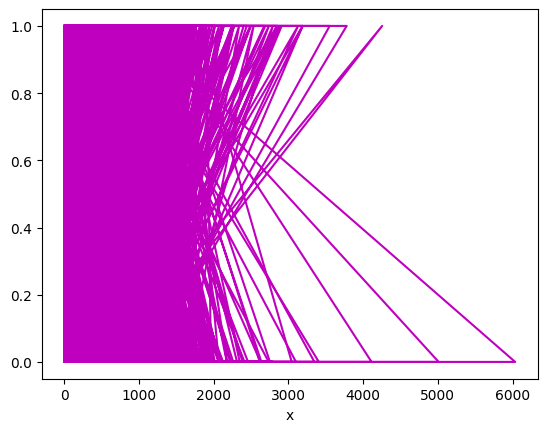

20 epochs done!


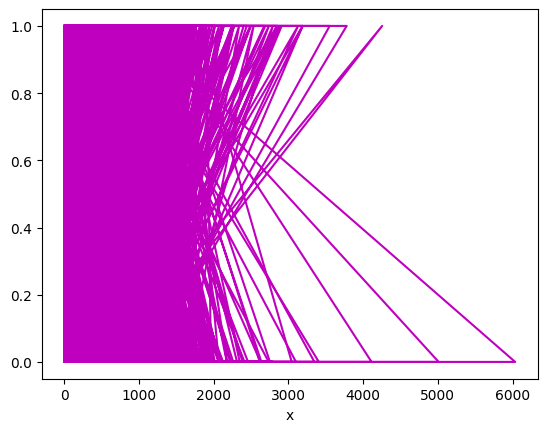

30 epochs done!


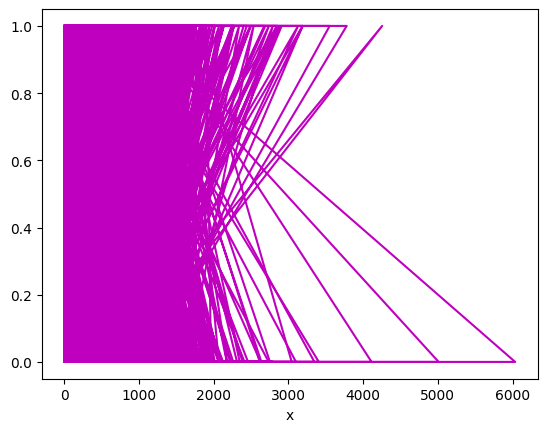

40 epochs done!


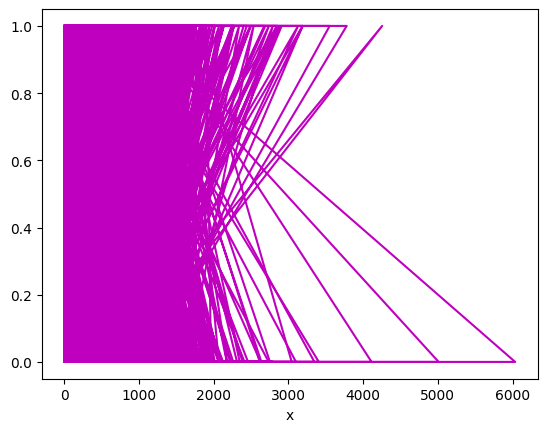

50 epochs done!


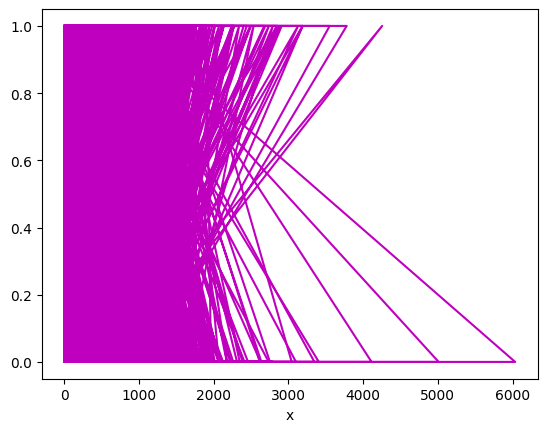

60 epochs done!


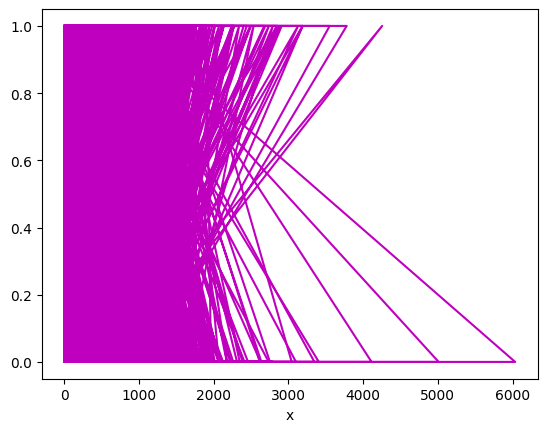

70 epochs done!


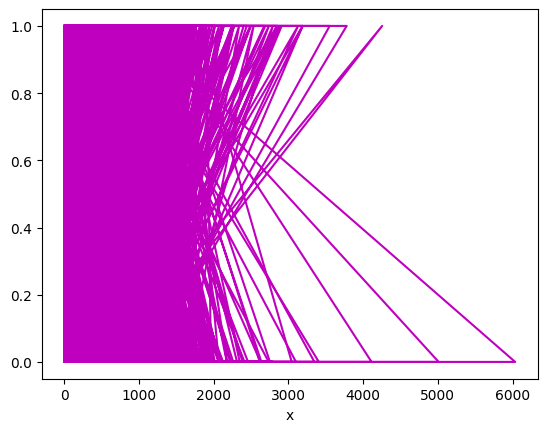

80 epochs done!


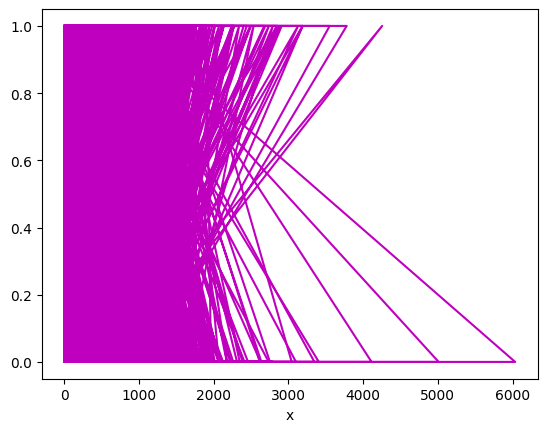

90 epochs done!


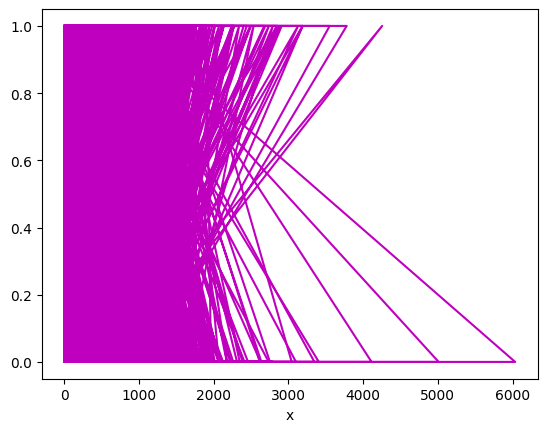

100 epochs done!


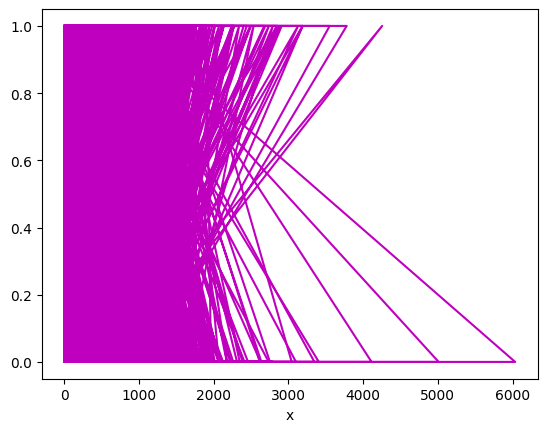

In [6]:
model = one_layer_net(22, 1, 2)
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values)
epochs=100
cost = []
total=0
for epoch in range(epochs):
    total=0
    epoch = epoch + 1
    for x, y in zip(X_train, y_train):
        yhat = model(x)
        loss = cross_entropy(yhat, y)
        loss.backward()
        """ optimizer.step()
        optimizer.zero_grad() """
        # get total loss 
        total+=loss.item() 
    cost.append(total)
    if epoch % 10 == 0:
        print(str(epoch)+ " " + "epochs done!") # visualze results after every 1000 epochs   
        # plot the result of function approximator
        # plt.plot(X_train.numpy(), model(X_train).detach().numpy())
        plt.plot(X_train.numpy(), y_train.numpy(), 'm')
        plt.xlabel('x')
        plt.show()